In [1]:
import pandas as pd

data = pd.read_csv('demanda.csv')

data.head()

,fecha,producto,demanda
0,2018-01-01,CERVEZA_LATA_350ML,182.0
1,2018-01-02,CERVEZA_LATA_350ML,176.0
2,2018-01-03,CERVEZA_LATA_350ML,181.0
3,2018-01-04,CERVEZA_LATA_350ML,183.0
4,2018-01-05,CERVEZA_LATA_350ML,181.0


In [2]:
data.describe()

,demanda
count,1826.000000
mean,192.845016
std,12.064374
min,159.000000
25%,185.000000
50%,193.000000
75%,202.000000
max,232.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   fecha     1826 non-null   object 
 1   producto  1826 non-null   object 
 2   demanda   1826 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.9+ KB


In [4]:
data.isnull().sum()

fecha       0
producto    0
demanda     0
dtype: int64

In [5]:
# Convertir columna fecha a datetime

data['fecha'] = pd.to_datetime(data['fecha'])

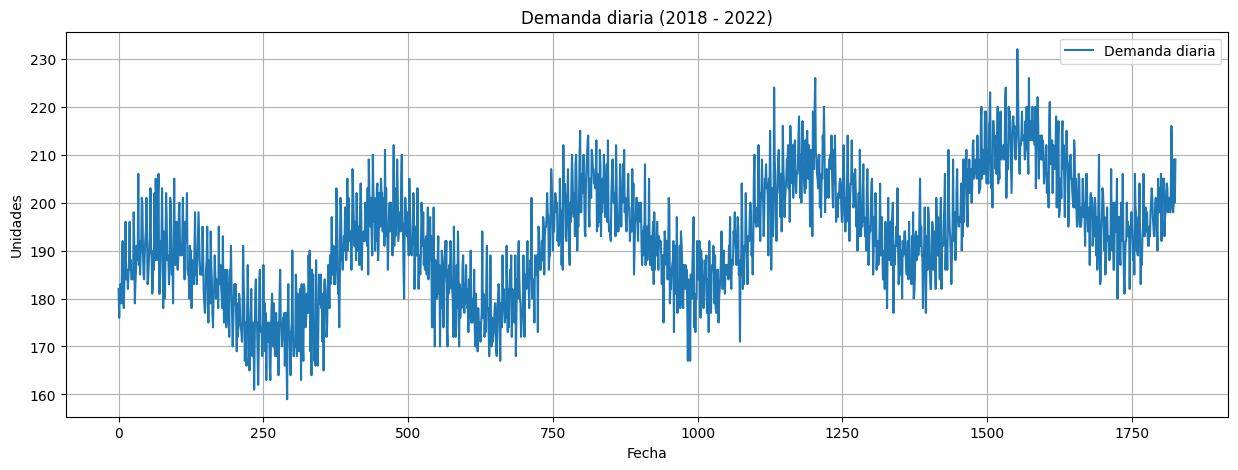

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(data['demanda'], label='Demanda diaria')
plt.title("Demanda diaria (2018 - 2022)")
plt.xlabel("Fecha")
plt.ylabel("Unidades")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
# Establecer fecha como indice

data.set_index('fecha', inplace=True)

In [8]:
# Usamos 4 años para entrenamiento y 1 año para test (2022)

train = data[:'2021']
test = data['2022':]

# Preprocesamiento

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar demanda
scaler = MinMaxScaler()
data['scaled'] = scaler.fit_transform(data[['demanda']])


In [10]:
import numpy as np

# Crear ventanas deslizantes

# Días 1 al 7  → predice día 8  
# Días 2 al 8  → predice día 9  
# Días 3 al 9  → predice día 10  

n_lags = 7
series = data['scaled'].values
fechas = data.index

X, y, fechas_y = [], [], []

for i in range(n_lags, len(series)):
    X.append(series[i - n_lags:i])
    y.append(series[i])
    fechas_y.append(fechas[i])

# ✅ Corrección: convertir a np.array para poder comparar
fechas_y = np.array(fechas_y)

split_date = pd.to_datetime('2022-01-01')
train_mask = fechas_y < split_date
test_mask = fechas_y >= split_date

X = np.array(X)
y = np.array(y)

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Simple RNN

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# MODELO SIMPLE RNN
modelo_rnn = Sequential()
modelo_rnn.add(SimpleRNN(64, return_sequences=True, activation='tanh', input_shape=(X_train_rnn.shape[1], 1)))
modelo_rnn.add(SimpleRNN(32, activation='tanh'))
modelo_rnn.add(Dense(1))

modelo_rnn.compile(optimizer='adam', loss='mse')
modelo_rnn.fit(X_train_rnn, y_train, validation_split=0.2, epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=1)


Epoch 1/50


C:\Users\Diego\anaconda3\envs\gpu_env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0226 - val_loss: 0.0076
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0103
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0073
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0066
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0071 - val_loss: 0.0076
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0072
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0064


In [12]:
# PREDICCIÓN
pred_rnn = modelo_rnn.predict(X_test_rnn).flatten()
pred_rnn_inv = scaler.inverse_transform(pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


In [13]:
# MÉTRICAS
mae_rnn = mean_absolute_error(y_test_inv, pred_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, pred_rnn_inv)
print(f"Simple RNN =  MAE: {mae_rnn:.2f} | MSE: {mse_rnn:.2f} | RMSE: {rmse_rnn:.2f} | R²: {r2_rnn:.3f}")

Simple RNN =  MAE: 4.37 | MSE: 31.20 | RMSE: 5.59 | R²: 0.645


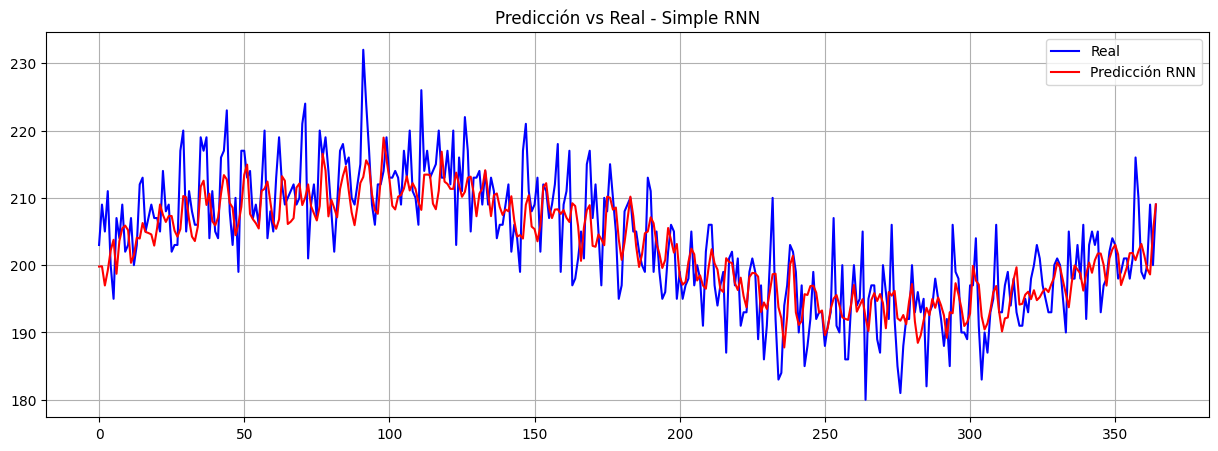

In [14]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_rnn_inv, label='Predicción RNN', linestyle='-', color='red')
plt.title("Predicción vs Real - Simple RNN")
plt.legend()
plt.grid(True)
plt.show()

# Red GRU (Unidades Recurrentes Cerradas)

In [15]:
from tensorflow.keras.layers import GRU, Dense, Input


# MODELO GRU
modelo_gru = Sequential()
modelo_gru.add(Input(shape=(X_train_rnn.shape[1], 1)))   # (timesteps, features)
modelo_gru.add(GRU(64, return_sequences=True, activation='tanh'))
modelo_gru.add(GRU(32, activation='tanh'))
modelo_gru.add(Dense(1))

modelo_gru.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_gru.fit(X_train_rnn, y_train,
               validation_split=0.2,
               epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
               verbose=1)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0564 - val_loss: 0.0085
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0100 - val_loss: 0.0084
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0081
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0082
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0081
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0078
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0082
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - val_l

In [16]:
# PREDICCIÓN
pred_gru = modelo_gru.predict(X_test_rnn).flatten()
pred_gru_inv = scaler.inverse_transform(pred_gru.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


In [17]:
# MÉTRICAS
mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)
mse_gru = mean_squared_error(y_test_inv, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_inv, pred_gru_inv)

print(f"GRU Profunda = MAE: {mae_gru:.2f} | MSE: {mse_gru:.2f} | RMSE: {rmse_gru:.2f} | R²: {r2_gru:.3f}")

GRU Profunda = MAE: 4.41 | MSE: 31.30 | RMSE: 5.59 | R²: 0.644


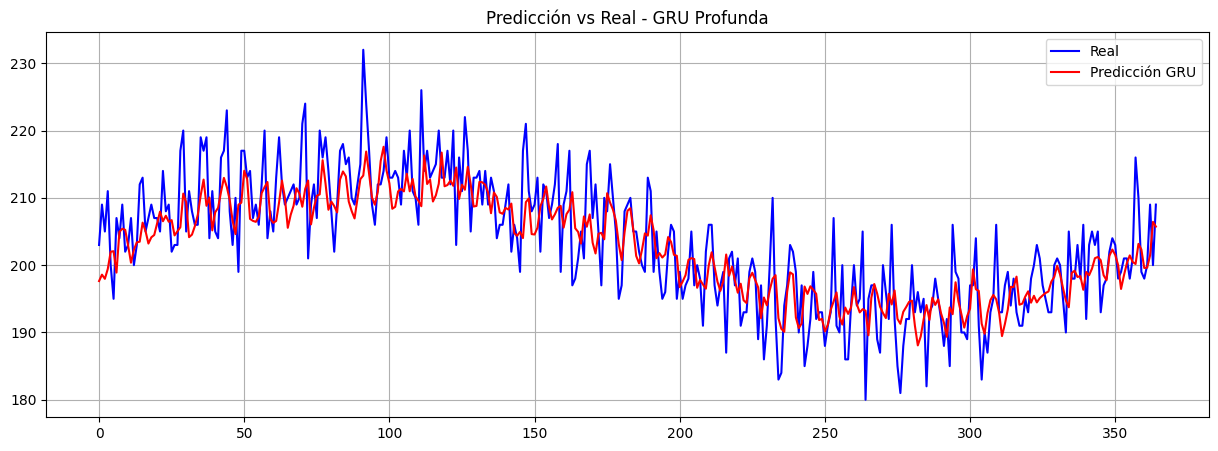

In [18]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_gru_inv, label='Predicción GRU', linestyle='-', color='red')
plt.title("Predicción vs Real - GRU Profunda")
plt.legend()
plt.grid(True)
plt.show()

# Red LSTM (Memoria larga a corto plazo)

In [19]:
from tensorflow.keras.layers import LSTM, Dense, Input

# MODELO LSTM
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train_rnn.shape[1], 1)))   # (timesteps, features)
modelo_lstm.add(LSTM(64, return_sequences=True, activation='tanh'))
modelo_lstm.add(LSTM(32, activation='tanh'))
modelo_lstm.add(Dense(1))

modelo_lstm.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_lstm.fit(X_train_rnn, y_train,
                validation_split=0.2,
                epochs=50,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=1)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0879 - val_loss: 0.0134
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0080
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0077
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0083
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0076
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0079
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0082
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0075
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_l

In [20]:

# PREDICCIÓN
pred_lstm = modelo_lstm.predict(X_test_rnn).flatten()
pred_lstm_inv = scaler.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


In [21]:
# MÉTRICAS
mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_inv, pred_lstm_inv)

print(f"LSTM Profunda = MAE: {mae_lstm:.2f} | MSE: {mse_lstm:.2f} | RMSE: {rmse_lstm:.2f} | R²: {r2_lstm:.3f}")


LSTM Profunda = MAE: 4.62 | MSE: 34.70 | RMSE: 5.89 | R²: 0.605


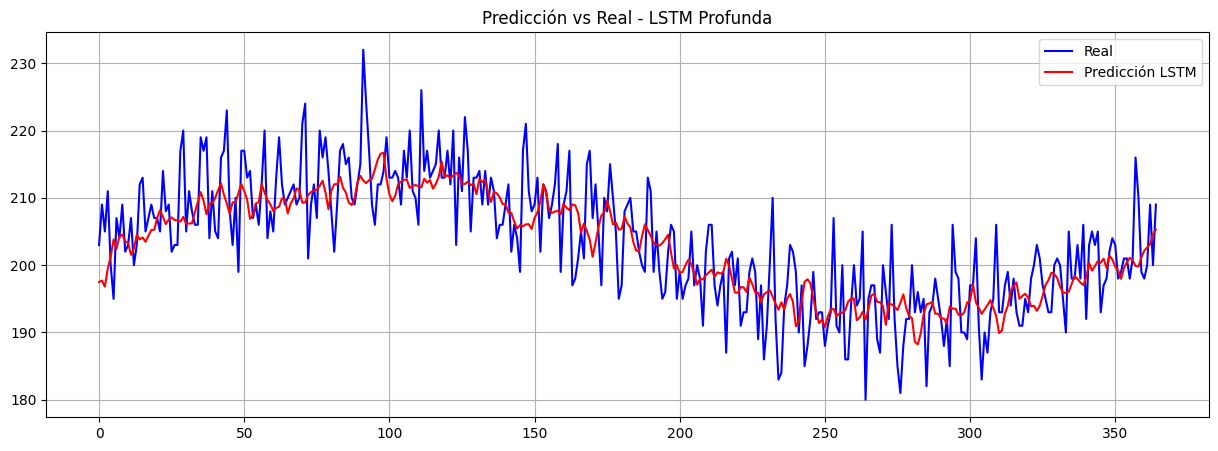

In [22]:

# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_lstm_inv, label='Predicción LSTM', linestyle='-', color='red')
plt.title("Predicción vs Real - LSTM Profunda")
plt.legend()
plt.grid(True)
plt.show()

# Creacion de Variables Exogenas

In [23]:
import pandas as pd
import numpy as np
import holidays
from sklearn.preprocessing import MinMaxScaler

# Cargar el dataset original
df = pd.read_csv('demanda.csv')
df.set_index('fecha', inplace=True)
df.index = pd.to_datetime(df.index)

# Feriados en Chile para todos los años del dataset
years = df.index.year.unique()
feriados_chile = holidays.country_holidays('CL', years=years)

# Variables exógenas
# Convertir fechas de feriados a datetime explícitamente
feriados_chile_dt = pd.to_datetime(list(feriados_chile.keys()))
df['es_feriado'] = df.index.isin(feriados_chile_dt).astype(int)
df['es_fin_semana'] = df.index.weekday.isin([5, 6]).astype(int)           # 1 si es sábado o domingo
df['dia_semana'] = df.index.weekday                                       # 0=Lunes, ..., 6=Domingo
df['mes'] = df.index.month                                                # 1 a 12
df['dia_del_anio'] = df.index.dayofyear                                   # 1 a 365
df['tendencia'] = np.arange(len(df)) / len(df)                            # tendencia lineal normalizada


# Escalar la demanda
scaler_y = MinMaxScaler()
df['scaled'] = scaler_y.fit_transform(df[['demanda']])

# Variables exógenas que se usarán
features_exogenas = ['es_feriado', 'es_fin_semana', 'dia_semana', 'mes', 'dia_del_anio', 'tendencia']

# Escalar variables exógenas
scaler_x = MinMaxScaler()
df[features_exogenas] = scaler_x.fit_transform(df[features_exogenas])

# Preprocesamiento

In [24]:
# Variables exógenas y target
features_exogenas = ['es_feriado', 'es_fin_semana', 'dia_semana', 'mes', 'dia_del_anio', 'tendencia']
target = 'scaled'

# Construcción de ventanas multivariadas
n_lags = 7 # (aqui estamos creando ventanas NO lags)
data_array = df[features_exogenas + [target]].values
fechas = df.index

X, y, fechas_y = [], [], []
for i in range(n_lags, len(data_array)):
    X.append(data_array[i - n_lags:i, :-1])  # ventanas de exógenas
    y.append(data_array[i, -1])              # target
    fechas_y.append(fechas[i])

X = np.array(X)
y = np.array(y)
fechas_y = np.array(fechas_y)

# Separar por fecha como lo hacías tú
split_date = pd.to_datetime('2022-01-01')
train_mask = fechas_y < split_date
test_mask = fechas_y >= split_date

X_train_mv = X[train_mask]
X_test_mv = X[test_mask]
y_train_mv = y[train_mask]
y_test_mv = y[test_mask]


# Simple RNN

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# MODELO RNN
modelo_rnn = Sequential()
modelo_rnn.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_rnn.add(SimpleRNN(64, return_sequences=True, activation='tanh'))
modelo_rnn.add(SimpleRNN(32, activation='tanh'))
modelo_rnn.add(Dense(1))

modelo_rnn.compile(optimizer='adam', loss='mse')

# ENTRENAMIENTO
modelo_rnn.fit(X_train_mv, y_train_mv,
               validation_split=0.2,
               epochs=50,
               callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
               verbose=1)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1161 - val_loss: 0.0096
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.0106
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0096
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0081 - val_loss: 0.0138
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078 - val_loss: 0.0105
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0105


In [26]:
# PREDICCIÓN
pred_rnn = modelo_rnn.predict(X_test_mv).flatten()
pred_rnn_inv = scaler_y.inverse_transform(pred_rnn.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


In [27]:
# MÉTRICAS
mae_rnn = mean_absolute_error(y_test_inv, pred_rnn_inv)
mse_rnn = mean_squared_error(y_test_inv, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_inv, pred_rnn_inv)

print(f"Simple RNN = MAE: {mae_rnn:.2f} | MSE: {mse_rnn:.2f} | RMSE: {rmse_rnn:.2f} | R²: {r2_rnn:.3f}")

Simple RNN = MAE: 6.55 | MSE: 67.35 | RMSE: 8.21 | R²: 0.234


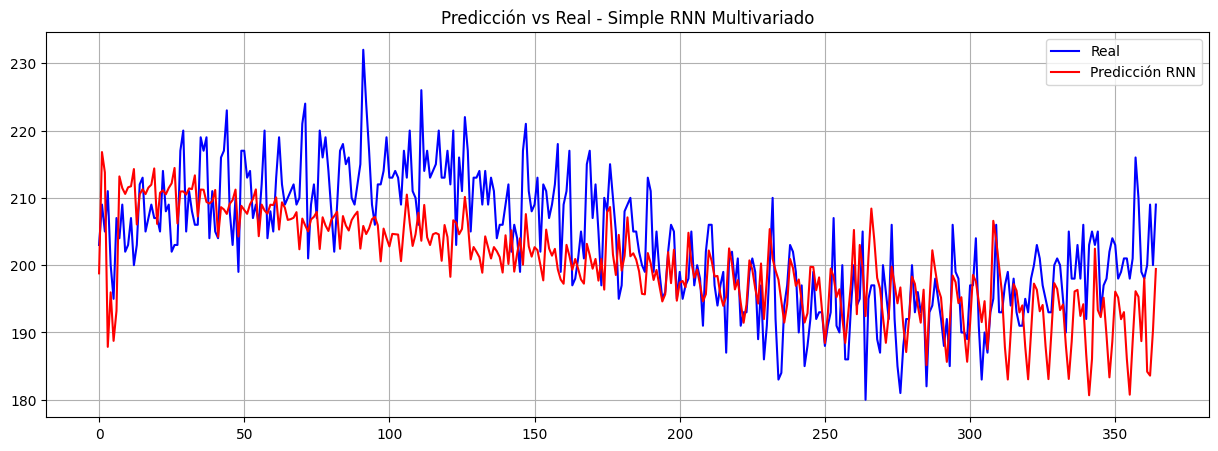

In [28]:
# GRÁFICO
plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_rnn_inv, label='Predicción RNN', linestyle='-', color='red')
plt.title("Predicción vs Real - Simple RNN Multivariado")
plt.legend()
plt.grid(True)
plt.show()

# Red GRU

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input

# Crear modelo GRU multivariado
modelo_gru = Sequential()
modelo_gru.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_gru.add(GRU(64, return_sequences=True, activation='tanh'))
modelo_gru.add(GRU(32, activation='tanh'))
modelo_gru.add(Dense(1))

modelo_gru.compile(optimizer='adam', loss='mse')


# Entrenamiento con early stopping
modelo_gru.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0422 - val_loss: 0.0100
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0091
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0086
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - val_loss: 0.0086
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0089
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0085
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0116
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - val_loss: 0.0096
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0095


In [30]:
# Predicción del conjunto de test
pred_gru = modelo_gru.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_gru_inv = scaler_y.inverse_transform(pred_gru.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 


In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_gru = mean_absolute_error(y_test_inv, pred_gru_inv)
mse_gru = mean_squared_error(y_test_inv, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
r2_gru = r2_score(y_test_inv, pred_gru_inv)

print(f"GRU Multivariado")
print(f"MAE: {mae_gru:.2f}")
print(f"MSE: {mse_gru:.2f}")
print(f"RMSE: {rmse_gru:.2f}")
print(f"R²: {r2_gru:.3f}")


GRU Multivariado
MAE: 5.49
MSE: 46.10
RMSE: 6.79
R²: 0.475


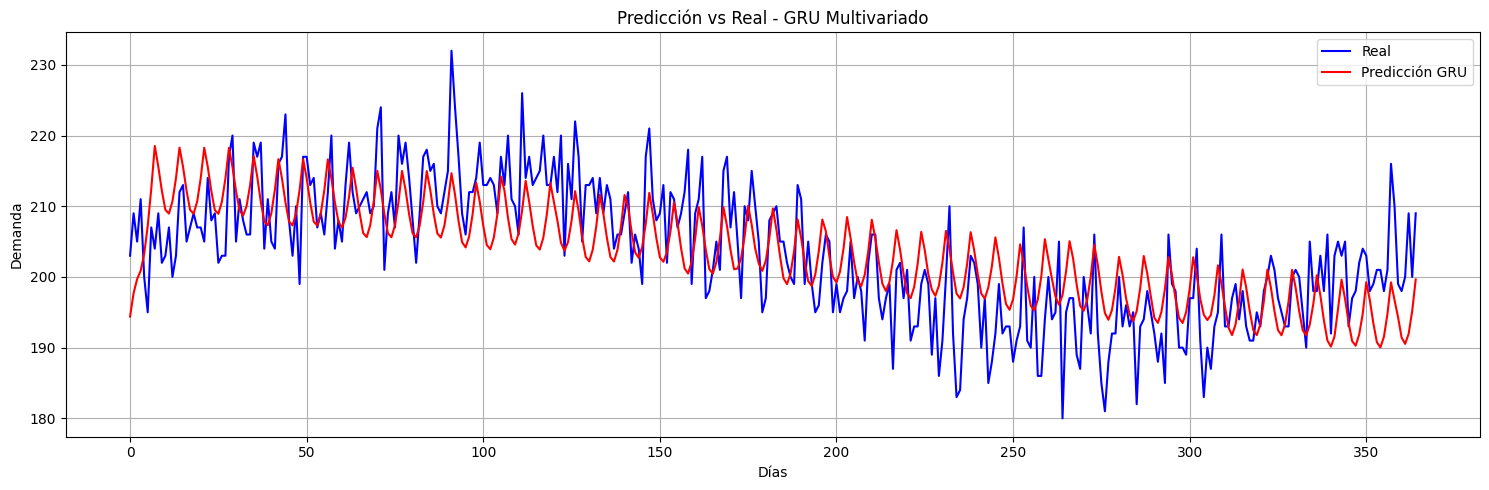

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_gru_inv, label='Predicción GRU', linestyle='-', color='red')
plt.title("Predicción vs Real - GRU Multivariado")
plt.xlabel("Días")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# LSTM

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Crear modelo LSTM multivariado
modelo_lstm = Sequential()
modelo_lstm.add(Input(shape=(X_train_mv.shape[1], X_train_mv.shape[2])))  # (timesteps, features)
modelo_lstm.add(LSTM(64, return_sequences=True, activation='tanh'))
modelo_lstm.add(LSTM(32, activation='tanh'))
modelo_lstm.add(Dense(1))

modelo_lstm.compile(optimizer='adam', loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

# Entrenamiento con early stopping
modelo_lstm.fit(
    X_train_mv, y_train_mv,
    validation_split=0.2,
    epochs=50,
    callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1023 - val_loss: 0.0124
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - val_loss: 0.0107
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0100
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0095
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0090
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0086
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0095
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0087
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0098
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0084
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0107
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_l

In [34]:
# Predicción del conjunto de test
pred_lstm = modelo_lstm.predict(X_test_mv).flatten()

# Inversión del escalado para comparar en unidades reales
pred_lstm_inv = scaler_y.inverse_transform(pred_lstm.reshape(-1, 1)).flatten()
y_test_inv = scaler_y.inverse_transform(y_test_mv.reshape(-1, 1)).flatten()


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 


In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_lstm = mean_absolute_error(y_test_inv, pred_lstm_inv)
mse_lstm = mean_squared_error(y_test_inv, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_inv, pred_lstm_inv)

print(f"LSTM Multivariado")
print(f"MAE: {mae_lstm:.2f}")
print(f"MSE: {mse_lstm:.2f}")
print(f"RMSE: {rmse_lstm:.2f}")
print(f"R²: {r2_lstm:.3f}")


LSTM Multivariado
MAE: 4.12
MSE: 26.56
RMSE: 5.15
R²: 0.698


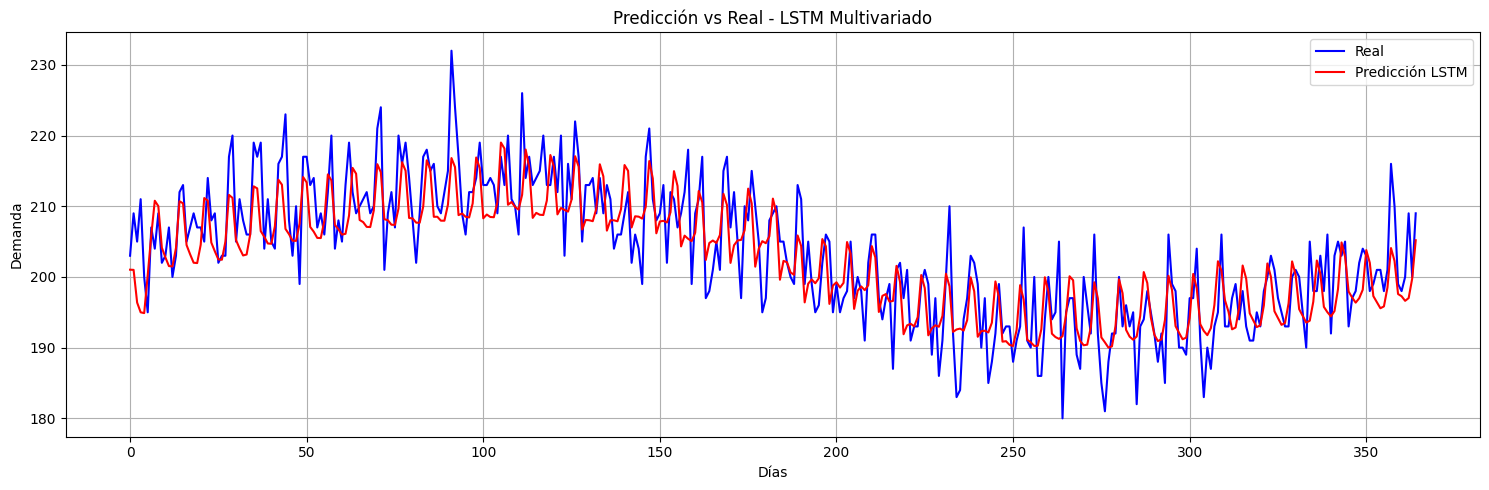

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(pred_lstm_inv, label='Predicción LSTM', linestyle='-', color='red')
plt.title("Predicción vs Real - LSTM Multivariado")
plt.xlabel("Días")
plt.ylabel("Demanda")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
